<a href="https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_2_toy_dw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics of Behavior Tutorial II - Part 2

In this session, we will expand on the semi-analytic calculations of notebook_1, and infer the transfer operator dynamics directly from simulations of the particle in a double well.

Before we start, let's load the environment and the repository

In [1]:
# Environment setup
!pip install -q -r https://raw.githubusercontent.com/AntonioCCosta/DPG_PhysicsBehavior_2026/main/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 5.6 MB/s eta 0:00:00


In [2]:
import os

if not os.path.exists("DPG_PhysicsBehavior_2026"):
    !git clone https://github.com/AntonioCCosta/DPG_PhysicsBehavior_2026.git
else:
    %cd DPG_PhysicsBehavior_2026
    !git pull
    %cd ..

import sys, platform
print("Python:", sys.version)
print("Platform:", platform.platform())

Cloning into 'DPG_PhysicsBehavior_2026'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 194 (delta 18), reused 6 (delta 3), pack-reused 157 (from 1)
Receiving objects: 100% (194/194), 35.12 MiB | 12.23 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.113+-x86_64-with-glibc2.35


In [3]:
import h5py
import numpy as np
import numpy.ma as ma
sys.path.append('./DPG_PhysicsBehavior_2026/utils')
import operator_calculations as op_calc
import delay_embedding as embed
import partition_methods as cl
import coarse_graining as cgm
import matplotlib.pyplot as plt

## Stochastic dynamics on a 1d double well

In notebook_1, we directly used the analytical expression to solve the Fokker-Planck equation using a finite-difference approach. However, in most real world scenarios, the equations of motion are unavailable, and instead we only have access to a finite set of observations. Here, we will see how we can directly approximate the transfer operator and its eigenspectrum directly from observations.

Let's consider again overdamped Langevin dynamics on a potential landscape,

$$
\dot{x}(t) = -\partial_x V(x) + \sqrt{2 T_x}\,\eta(t),
\qquad \langle \eta(t)\eta(t') \rangle = \delta(t-t').
$$

Where the potential landscape is given by of a double well type:

$$
V(x) = \frac{x^4}{4} -\mu \frac{x^2}{2}
$$


## Estimating the transition matrix from data

The finite time operator $P_\tau$ estimated is effectively a transition probability matrix among state space regions, which can be estimated directly from time series observations. The simplest way to do this is to simply partition the domain and count transitions among state space regions. This is called the Ulam-Galerkin method.

Technically speaking, the Galerkin projection takes the infinite dimensional operator onto an $N\times N$ operator of finite rank by truncating an infinite dimensional set of basis functions at a finite $N$. Ulam's method uses characteristic functions as the basis for this projection,

$$
\zeta_i(x) = \begin{cases}
    1, & \text{for $x \in s_i$}\\
    0, & \text{otherwise}
    \end{cases}.
$$

We thus partition the space into $N$ connected sets with nonempty and disjoint interior that covers $M$: $M = \cup_{i=1}^N s_i$, and approximate the transfer operator as a Markov chain by counting transitions from $s_i$ to $s_j$ in a finite time $\tau$. Given T observations, a set of $N$ partitions, and a transition time $\tau$, we compute

$$
C_{ij}(\tau) = \sum_{t=0}^{T-\tau}\zeta_i(x(t))\zeta_j(x(t+\tau))
$$

The maximum likelihood estimator of the transition matrix is obtained by simply row normalizing the count matrix,

$$
P_{ij}(\tau) = \frac{C_{ij}(\tau)}{\sum_j C_{ij}(\tau)}.
$$

To partition the state space in a way that can generalize to higher dimensions, we we will use the k-means algorithm to identify $N$ Voronoi cells. Let's see how that works for our simulations.

In [4]:
from numba import jit,prange
@jit(nopython=True, parallel=True)
def simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling):
    n_sims = len(x0s)
    sims = np.zeros((n_sims, int(max_iters/downsampling)))
    for ks in prange(n_sims):
        x0 = x0s[ks]
        x = x0
        for i in range(max_iters):
            new_x = x + (-x**3+mu*x) * dt + np.sqrt(2 * Tx) * np.random.normal(0, np.sqrt(dt))
            x = new_x
            if i%downsampling==0:
                sims[ks, int(i/downsampling)] = x
    return sims

Tx=3e-1 #temperature
T = 1000
dt=1e-3
max_iters=int(T/dt)
final_dt = 1e-1
downsampling = int(final_dt/dt)
n_sims = 500
x0s = np.random.uniform(-1,1,n_sims)
mu=1
sims = simulate_dw(x0s,mu, Tx, dt, max_iters,downsampling)

In [5]:
N=1000
#labels_all is an array with the partition that each point in the time series belongs to
#centers is the centroid of each k-means cluster
labels_all,centers = cl.kmeans_partition(np.hstack(sims).reshape(-1,1),N,batchsize=10000,return_centers=True)

To estimate the discrete time transition matrix, we choose a delay of $\tau=0.1\text{s}$, which is smaller than the transition time between wells, but also long enough to enable transitions out of a single cell. We will return to the question of $\tau$ selection at the end.


As you can see below, the implied timescales of the inferred transition matrix, $t^\text{imp}_k = |\hat{\Lambda}|_k^{-1} = -\tau/\log(\lambda_k(\tau))$ match the theoretical predictions obtained through Kramer's approximation (the match would be better with a larger $\mu/T_x$ and longer simulation times but this would take too long to compute in this tutorial, but try it yourself!)

In [7]:
delay=1
P_emp = op_calc.transition_matrix(labels_all,delay)
R = op_calc.get_reversible_transition_matrix(P_emp) #ensure reversibility
eigvals_emp,eigvecs_emp = op_calc.sorted_spectrum(R,k=5)
timp=-delay*final_dt/np.log(eigvals_emp[1].real)

print('estimated timescale: {:.4f}'.format(timp))

def kramers_rate(mu, Tx):
    # Well minimum
    x_m = np.sqrt(mu)
    # Barrier top
    x_s = 0.0

    V = lambda x,mu: x**4/4-mu*x**2/2

    # Second derivatives
    Vpp_m = 3 * x_m**2 - mu  # V''(x_m)
    Vpp_s = 3 * x_s**2 - mu  # V''(x_s)

    # Barrier height
    DeltaV = V(x_s, mu) - V(x_m, mu)

    # Kramers rate (overdamped, 1D)
    k = np.sqrt(abs(Vpp_s) * Vpp_m) / (2 * np.pi) * np.exp(-DeltaV / Tx)
    return k

print('analytical timescale: {:.4f}'.format(0.5/kramers_rate(mu,Tx))) # the factor of 2 comes from the fact that we have a symmetric double well, see notebook_1_theory_dw.ipynb

estimated timescale: 4.1770
analytical timescale: 5.1115


We can also compare this with the transition rates obtained from the data

In [8]:
def state_lifetime(states,tau):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries))*tau)
    return durations

delta=1e-3*np.sqrt(mu)
xs = np.hstack(sims)
states = np.zeros_like(xs)
states[xs >  delta] = +1
states[xs < -delta] = -1
states = np.ma.masked_equal(states, 0)
durs = np.hstack(state_lifetime(states,final_dt))

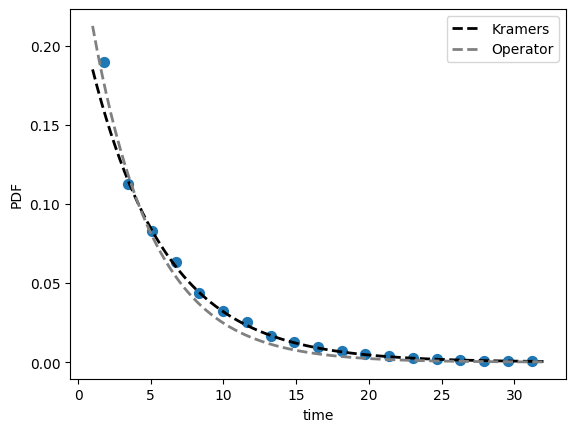

In [15]:
tmin=1
tmax=np.percentile(durs,99.9)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50)
times = np.linspace(tmin,tmax,100)
_,b=np.polyfit(centers_t,np.log(freqs),1) #just to get the offset
rate = 2*kramers_rate(mu,Tx) #2x because it's only the time to the boundary
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='k',lw=2,ls='--',label=r'Kramers')
rate = 1/timp # the match with the simulations would get better with more data
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='gray',lw=2,ls='--',label=r'Operator')
# plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()

Besides the slowest timescale matching the expectation from our analytical analysis, the inferred slow eigenvector $\phi_2$ should resemble the slowest mode of the semi-analytical operator (up to a sign flip). Let's check

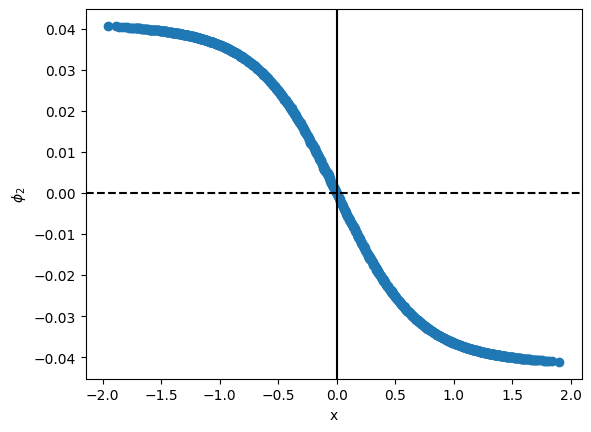

In [16]:
eigvecs_emp = eigvecs_emp.real
eigvecs_emp = eigvecs_emp/np.linalg.norm(eigvecs_emp,axis=0)
phi2_emp = eigvecs_emp[:,1]
sorted_indices = np.argsort(phi2_emp)
plt.scatter(centers[sorted_indices],phi2_emp[sorted_indices])
plt.ylabel(r'$\phi_2$')
plt.xlabel('x')
plt.axvline(0,c='k')
plt.axhline(0,c='k',ls='--')
plt.show()


Given $\phi_2$, we can now proceed as in [Notebook 1](https://https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb) and find the location of the energy barrier by maximizing the overall coherence of metastable sets along $\phi_2$.

In [17]:
inv_measure_emp = op_calc.stationary_distribution(P_emp)
cr,rho_sets,ms,idx,km_labels = cgm.optimal_partition(phi2_emp,inv_measure_emp,P_emp,return_rho=True)

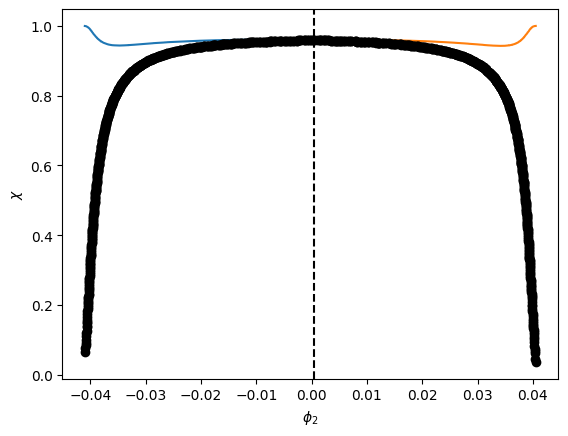

In [18]:
plt.plot(cr,rho_sets)
plt.plot(cr,np.min(rho_sets,axis=1),marker='o',c='k')
plt.axvline(cr[idx],c='k',ls='--')
plt.ylabel(r'$\chi$')
plt.xlabel(r'$\phi_2$')
plt.show()

As you can see, our entirely data-driven calculation recovers the slow modes of the dynamics, as well as the location of the energy barrier.

# Appendix 1 - $\tau$ selection




Since we are working with discretely sampled dynamics and a discrete time operator $P_\tau$, instead of the underlying infinitesimal operator $L$ introduced in [Notebook 1](https://colab.research.google.com/github/AntonioCCosta/DPG_PhysicsBehavior_2026/blob/main/notebooks/notebook_1_theory_dw.ipynb), we have to be careful in our selection of $\tau$ to preserve the transition dynamics.

Intuitively, once we discretize the state space, setting $\tau→0$ may be dangerous because we may enter a pathological numerical limit in which the transition matrix approaches an identity matrix: we don't leave enough time for the state to leave a partition. In the opposite limit, when $\tau$ is much larger than the mixing time of the dynamics, the transition matrix will essentially contain copies of the steady state distribution $\pi$ since the time between $s_i$ and $s_j$ is too long: $P_{ij}(\tau→\infty) \sim \pi$. In this limit, all eigenvalues except for the eigenvalue 1 tend to zero. However, due to finite data, the estimated transition probabilities will deviate from the true invariant density, resulting in a set of small but non-zero eigenvalues that become independent of $\tau$ when it is much larger that the mixing time.

For intermediate $\tau$ we should find an appropriate spectral gap. In addition, the Markovian nature of the dynamics implies that the inferred relaxation times reach a constant value that matches the underlying long timescale $\Lambda_2^{-1}$ of the system: the Chapman-Kolmogorov equation is verified $P_{n\tau}\rho = P^n_\tau\rho$, and thus $t^\text{imp}_k(n\tau)=\frac{-n\tau}{\log (\lambda_k(\tau)^n)}=t^\text{imp}_k( \tau)$. We choose $\tau^*$ in this intermediate regime, such that $\hat{\Lambda}_2$ is approximately constant and we have large spectral gap.

Let's estimate the eigenvalues $\lambda_k$ and implied timescales $t^\text{imp}_k$ as a function of the delay $\tau$.



In [78]:
delay_range = np.unique(np.array(np.logspace(0,2.75,20),dtype=int))
n_modes=10
eigvals_delay = np.zeros((delay_range.shape[0],n_modes))
tscales_delay = np.zeros((delay_range.shape[0],n_modes))
for kd,delay in enumerate(delay_range):
  P_emp = op_calc.transition_matrix(labels_all,delay)
  R = op_calc.get_reversible_transition_matrix(P_emp) #ensure reversibility
  eigvals = op_calc.sorted_spectrum(R,k=n_modes+1)[0]
  sorted_indices = np.argsort(eigvals.real)[::-1]
  lambdas = eigvals[sorted_indices][1:].real
  eigvals_delay[kd,:] = lambdas
  tscales_delay[kd,:] = -delay*final_dt/np.log(lambdas)
  print(delay)

1
2
3
5
7
10
14
20
28
39
54
76
106
148
206
288
402
562


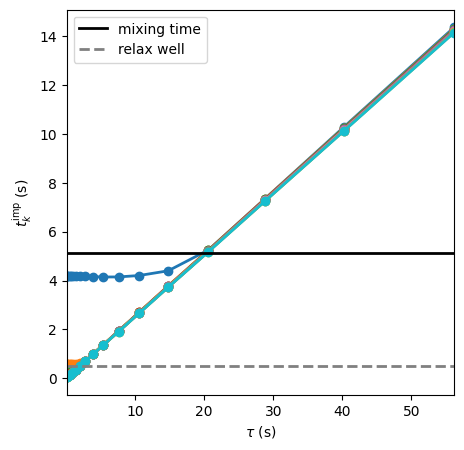

In [88]:
plt.figure(figsize=(5,5))
plt.plot(delay_range*final_dt,tscales_delay,lw=2,marker='o')
plt.axhline(1/(2*kramers_rate(mu,Tx)),c='k',lw=2,label='mixing time')
plt.axhline(0.5,c='gray',lw=2,ls='--',label='relax well')
plt.xlim(delay_range[0]*final_dt,delay_range[-1]*final_dt)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$t^\text{imp}_k$ (s)')
plt.legend()
plt.show()

As you can see above, the implied timescales of the operator start relatively constant, indicating that our sampling time is large enough to enable meaningful transitions among our fine $N=1000$ partitions. In addition, we see that for large $\tau$ the implied timescales grow linearly with $\tau$: we enter the regime in which these fast modes have mixed, and the eigenvalues become constant, and so $t^\text{imp}_k(\tau) \sim \tau$.

For $0.1\text{s}<\tau<5\text{s}$ we see that the slowest timescale is close to the Kramers' estimate and approximately constant, which indicates that the slow dynamics are Markovian in that regime according to the Chapman-Kolmogorov identity. In addition, the second slowest timescale is also non-zero for small $\tau$, and corresponds to the timescale of relaxation to a single well ($\sim 1\text{s}$). Beyond $\tau \sim 1\,text{s}$, this mode has mixed, and from then on the corresponding implied timescale grows linearly.

As you can see, analysing these curves lays bare the multiscale strucuture to the dynamics, and the appropriate coarse-graining needed at different timescales.

To lay bare the large time limit and the deviation from $\lambda_k(\tau→0)=0$, we can also plot the eigenvalues as a function of $\tau$. You can see that the theoretical prediction decays entirely to zero, whereas the inferred eigenvalues converge to a non-zero noise floor.

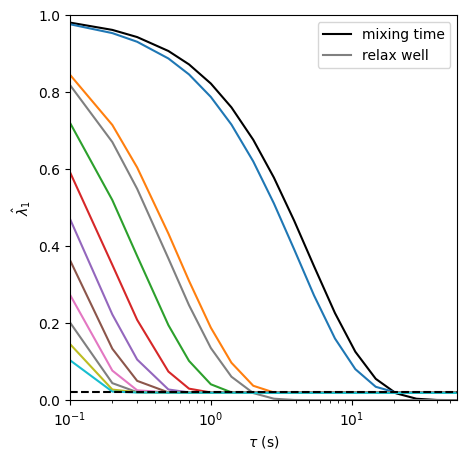

In [97]:
plt.figure(figsize=(5,5))
plt.plot(delay_range*final_dt,np.exp(-2*kramers_rate(mu,Tx)*delay_range*final_dt),c='k',label='mixing time')
plt.plot(delay_range*final_dt,np.exp(-2*1*delay_range*final_dt),c='gray',label='relax well')

plt.plot(delay_range*final_dt,eigvals_delay)
plt.xscale('log')
plt.xlim(delay_range[0]*final_dt,delay_range[-1]*final_dt)
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$\hat{\lambda}_1$')
plt.axhline(eigvals_delay[-1,0],c='k',ls='--')
plt.ylim(0,1)
plt.legend()
plt.show()

# Appendix 2 - Coarse-grained model

Using the coarse-graining into metastable states, and the result regarding the implied timescales of the operator, we see that for $\tau⪆0.5\,\text{s}$, we should be able to construct a 2-state Markov model that discards faster fluctuations and accurately captures the macroscopic transitions among wells. Let's test by estimating a coarse-grained transition matrix and making simulations.

In [108]:
label_traj=km_labels[labels_all]
delay=5
Pc = op_calc.transition_matrix(label_traj,delay)

In [109]:
from joblib import Parallel, delayed

def simulate(P,state0,iters):
    '''
    Monte Carlo simulation of the markov chain characterized by the matrix P
    state0: initial system
    iters: number of iterations of the simulation
    '''
    states = np.zeros(iters,dtype=int)
    states[0]=state0
    state=state0
    for k in range(1,iters):
        new_state = np.random.choice(np.arange(P.shape[1]),p=list(P[state,:]))
        state=new_state
        states[k]=state
    return states

n_sims=500
state0s = np.random.choice([0,1],n_sims)
n_iters=2000

sims_coarse = Parallel(n_jobs=-1)(delayed(simulate)(Pc.toarray(),state0,n_iters) for state0 in state0s)

In [110]:
all_durs = np.hstack([np.hstack(state_lifetime(ma.array(sim),final_dt*delay)) for sim in sims_coarse])

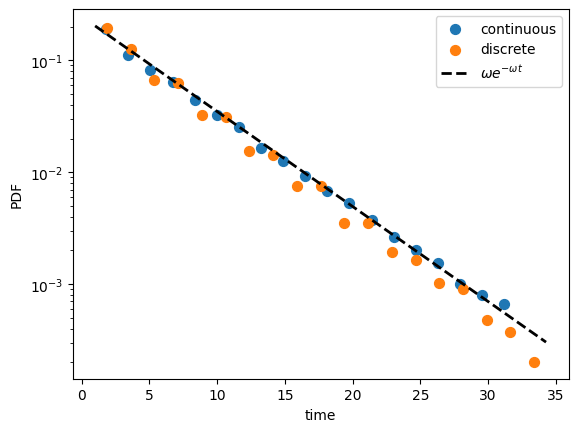

In [111]:
tmin=1
tmax=np.percentile(durs,99.9)
freqs,bin_edges = np.histogram(durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50,label='continuous')

tmax=np.percentile(all_durs,99.9)

freqs,bin_edges = np.histogram(all_durs, bins=np.linspace(tmin,tmax,20), density=True)
centers_t = (bin_edges[1:]+bin_edges[:-1])/2
plt.scatter(centers_t,freqs,marker='o',s=50,label='discrete')

times = np.linspace(tmin,tmax,100)
_,b=np.polyfit(centers_t,np.log(freqs),1) #just to get the offset
rate = 2*kramers_rate(mu,Tx) #2x because it's only the time to the boundary
plt.plot(times,np.exp(b)*np.exp(-rate*times),c='k',lw=2,ls='--',label=r'$\omega e^{-\omega t}$')
plt.yscale('log')
plt.ylabel('PDF')
plt.xlabel('time')
plt.legend()
plt.show()